# IMPORTING LIBRARIES

In [1]:
import random

import nltk
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

from nltk.corpus import stopwords

import re
from bs4 import BeautifulSoup          #To remove html tags while preprocessing reviews.

import spacy
import numpy as np

# EXTRACTING DATA 

In [2]:
file=open("train.ft.txt","r",encoding="utf8")
train_file_lines=[x for x in file]
file.close()

In [3]:
train_file_lines=random.sample(train_file_lines,100000)

In [4]:
train_file_lines

['__label__2 Mind opening, thought provoking!: Alan Watts has a amazing talent of explaining the complex in a way that is entertaining and easy to follow.\n',
 "__label__1 O'Reilly is a hypocrite.: All you have to do to realize how much of a lying hypocrite Bill is is to read the chapter about him in Al Franken's book. First he claimed to have won awards he did not, and then he tried to lie to cover it up. He pretends to be on some high moral plane when he is more lowly than the people he despises.\n",
 '__label__2 It is what it is...: This maintenance kit has prolonged the life of our workhorse HP printer. Great item!\n',
 '__label__2 amazing!: i was only expecting the first movie to find out that i got all four :) i couldnt be more happier\n',
 "__label__1 Not the best Shrek Movie: Wasn't as good as Shrek 1 & 2. Too long, slow paced, not enough jokes...actually boring at times.\n",
 '__label__1 Maybe A Good Game on PS 1: Big, chunky polygon graphics, long load times and long mid-game

# PRE-PROCESSING



## Word Preprocessing

In [5]:
#REMOVING STOPWORDS,NON-ENGLISH WORDS AND LEMMATIZING AND FILTERING WORDS WITH LENGTH LESS THAN min_word_length.
"""nltk.download("stopwords")
nltk.download("words")
nltk.download("wordnet")"""

stop_words = set(stopwords.words('english'))
english_words = set(nltk.corpus.words.words())

def remove_underscores(sentence):
    sentence = sentence.replace("_"," ")
    sentence = sentence.replace("\\","")
    return sentence

def remove_extra_words(sentence, min_word_length):     #remove stop words and meaningless words and lose the ones with length less than min_word_length.
    new_sentence=""
    for w in sentence.split():
        w=w.lower()
        if w in english_words and w not in stop_words and w.isalpha() and len(w)>min_word_length:
            new_sentence=new_sentence+" "+w
    return new_sentence

def lemmatize_and_filter(sentence):        #to lemmatize words 
    sent = ""
    for word in sentence.split():
        word=word.lower()
        sent= sent+" "+lemmatizer.lemmatize(word)
    return(sent)

### postag screening
AN OPTIONAL PREPROCESSING

In [6]:
"""from spacy.cli.download import download
download(model="en_core_web_sm")"""

'from spacy.cli.download import download\ndownload(model="en_core_web_sm")'

In [7]:

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

"""
def postags_screening(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):         #Do lemmatization keeping only Noun, Adj, Verb, Adverb
"""
def postags_screening(texts, allowed_postags=['NOUN']):
    texts_out = []
    for sent in texts:
        doc=nlp(sent)
        sent=""
        for token in doc:
            if token.lemma_ not in ['-PRON-'] and token.pos_ in allowed_postags:        ##Do lemmatization removing pronouns and keeping only Noun
                sent=sent+" "+str(token.lemma_)
        texts_out.append(sent)
    return texts_out


## Sentence Preprocessing

In [8]:
#re.sub(r'[^\w\s],"",string) to remove punctuations.
#re.sub(r'^https?:\/\/.*[\r\n]*', '', string) to remove urls.
#re.split("__label__[1|2]",string)[1] to get the 2nd element of the split, i.e, the review
#strip() to remove whitespaces
#re.findall("1|2", str(lines))[0] to store the first number encountered in the line of the review as the label of the review.
#BeautifulSoup(string, "lxml").text) to remove html tags


def split_label_review(data):
    #takes in list of raw data and returns list of string sentences and the list of their corresponding labels.
    labels = [int(re.findall("1|2", str(lines))[0]) for lines in data]
    reviews = [re.split("__label__[1|2]",str(lines))[1].strip().lower() for lines in data]
    return(reviews,labels)


def preprocessed_data(data):        #takes in list of raw data and returns list of processed string sentences and the list of their corresponding labels.
    reviews = [remove_extra_words(lemmatize_and_filter(BeautifulSoup(re.sub(r'[^\w\s]|^https?:\/\/.*[\r\n]*|\d+', '', remove_underscores(str(lines)).strip().lower()), "lxml").text),2) for lines in data]
    reviews = postags_screening(reviews)
    return(reviews)



# **Estimating number of topics**

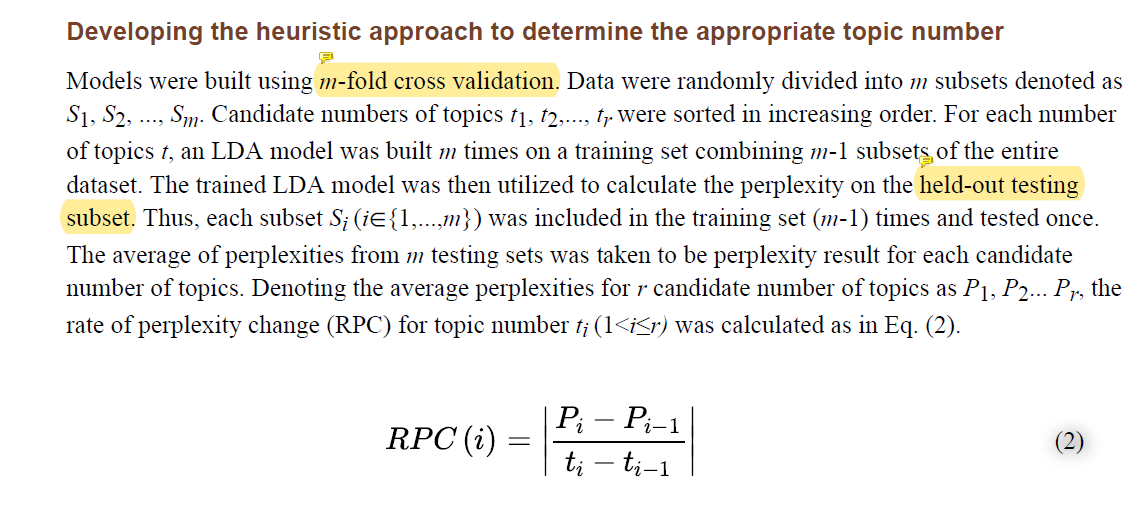

In [9]:
#K-fold cross validation
import numpy as np
from numpy import array
from sklearn.model_selection import KFold
# data sample
def k_fold(data,k):
    list_of_train_index = [[] for i in range(k)]
    list_of_test_index = list_of_train_index
    index=np.array([*range(len(data))])
    # prepare cross validation
    train_data=[]
    test_data=[]
    kfold = KFold(k, True,1)
    # enumerate splits
    c=0
    for train, test in kfold.split(index):
        list_of_train_index[c]=train.tolist()
        list_of_test_index[c] =test.tolist()
        c+=1
    return(list_of_train_index,list_of_test_index)

In [10]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

def estimate_topic_no(data_):
    k=10
    variable=int(len(data_)/k)*k
    data_= data_[:variable]  #so that the data can be equally divided into k parts
    perplexity_list=[]
    #number_of_topics = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
    number_of_topics = [int(x) for x in np.linspace(start = 50, stop = 150, num = 11)]
  
    for n in number_of_topics:
    
        train=k_fold(data_,k)[0]
        perplexity=0
        for list_ in train:
            data=[data_[i] for i in list_]
            vectorizer = CountVectorizer(analyzer='word')
            data_vectorized = vectorizer.fit_transform(data)
            """Materialize the sparse data
            data_dense = data_vectorized.todense()

            # Compute Sparsicity = Percentage of Non-Zero cells
            print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")"""
            # Build LDA Model
            lda_model = LatentDirichletAllocation(n_components=n)
            lda_output = lda_model.fit_transform(data_vectorized)
            perplexity=perplexity+lda_model.perplexity(data_vectorized)
        perplexity=perplexity/k
        perplexity_list.append(perplexity)
    perplexity_list=[(perplexity_list[i+1]-perplexity_list[i])/(number_of_topics[1]-number_of_topics[0]) for i in range(len(perplexity_list)-1) ] 
    number_of_topics=number_of_topics[:-1]
    #plt.plot(number_of_topics,perplexity_list)
    ind = perplexity_list.index(max(perplexity_list))-1
    print(number_of_topics[ind])
    return number_of_topics[ind]


In [11]:
"""#trial
choice=0      #0 for negative. 1 for positive

data = split_into_negative_positive(train_file_lines)[choice]
data = split_label_review(data)[0]
data = preprocessed_data(data)
data = postags_screening(data)
estimate_topic_no(data)"""

'#trial\nchoice=0      #0 for negative. 1 for positive\n\ndata = split_into_negative_positive(train_file_lines)[choice]\ndata = split_label_review(data)[0]\ndata = preprocessed_data(data)\ndata = postags_screening(data)\nestimate_topic_no(data)'

So clearly we can say that the point of change is approximately 1100. 

# CLUSTERING ON TF-IDF

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering


def cluster_formation(data,n_clusters):
    
    #n_clusters=1100
    vectorizer = TfidfVectorizer(smooth_idf=True)
    tf_idf = vectorizer.fit_transform(data)
    tf_idf=tf_idf.toarray()
    cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')        #‘ward’ minimizes the variance of the clusters being merged
    cluster.fit_predict(tf_idf)     #words acting as features and sentences(or documents) as samples.
    #max(cluster.labels) = 1100-1 = 1099
    cluster_index=[np.where(cluster.labels_==i)[0].tolist() for i in range(max(cluster.labels_)+1)]              
    #NOTE: np.where(cluster.labels_==i)  : returns a tuple with the 0th element as an array of indexes. Whereas np.where(cluster.labels_==i)[0] returns the array itself.

    cluster_index = [cluster_index[i] for i in np.argsort(np.array([len(i) for i in cluster_index]))[::-1]]  #Sorting the clusters lengthwise.
    return cluster_index



In [13]:
def cluster_to_sent(data,cluster_index):
    sentences=[]
    for i in cluster_index:
        s=""
        for j in i:
            s=s+" "+data[j]
        sentences.append(s)
        
    return sentences

# CLUSTERING REVIEWS: COSINE SIMILARITY

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
def most_sim_doc_index(sentences,user_querry):
    user_querry = user_querry.lower()
    sentences.append(user_querry)    #each sentence is 1 cluster of one or more reviews each
    response = ""

    cm = CountVectorizer().fit_transform(sentences)
    similarity_scores = cosine_similarity(cm[-1],cm)
    similarity_scores_list = similarity_scores.flatten().tolist()
    index=similarity_scores_list.index(sorted(similarity_scores_list,reverse=True)[1])
    sentences.pop()
    return index

# IMPLEMENTATION

In [28]:
data,labels = split_label_review(train_file_lines)
data = preprocessed_data(data)
    
cluster_num = estimate_topic_no(data)
    
clus_in=cluster_formation(data,cluster_num)
sentences=cluster_to_sent(data,clus_in)

C:\Users\hp\Anaconda3\envs\TCS\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass shuffle=True, random_state=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


120


In [36]:
def finalfun():
    input_review=input("Enter category:\n")
    index=most_sim_doc_index(sentences,input_review)
    choice=int(input("Enter 1 for negative,2 for positive:\n"))
    
    most_common_cluster=[train_file_lines[i] for i in clus_in[index]]
    
    final_text,labs=split_label_review(most_common_cluster)
    outcome=[]
    for i in range(len(labs)):
        if labs[i]==choice:
            outcome.append(final_text[i])
            
    chstr=["Negative","Positive"]
    print("All the {} outcomes for category {} are:".format(chstr[choice-1],input_review),outcome)

In [37]:
for i in range(3):
    finalfun()

Enter category:
book
Enter 1 for negative,2 for positive:
1
All the Negative outcomes for category book are: ['same book different title: like many other reviews i have read on this book, i found it very disappointing, and i only read it because in the past james patterson has written some fine stuff. the last two books he has written on alex cross is very similar to his earlier stories, did he merely change the names of the people kidnapped and murdered. i think so. i have vowed never to read another jp book again. vicki, canberra, australia', "waste of paper: i recently had to read this book as part of my english gcse and i can honestly say that much paper has been wasted and our trees are being destroyed to churn out a book, which is quite frankly absolutly awfull. i also am very glad that i was not around to ever meet thomas hardy as from this book it sounds to me that he may well of been a manic depresent, also in most, if not all, of his other books they all end in a very sad a d